In [1]:
print("\n... IMPORTS STARTING ...\n")

# JUUUUUST IN CASE
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

print("\n\tVERSION INFORMATION")
# Machine Learning and Data Science Imports
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_hub as tfhub; print(f"\t\t– TENSORFLOW HUB VERSION: {tfhub.__version__}");
import tensorflow_addons as tfa; print(f"\t\t– TENSORFLOW ADDONS VERSION: {tfa.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None;
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t– SKLEARN VERSION: {sklearn.__version__}");
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from pandarallel import pandarallel; pandarallel.initialize();
from sklearn.model_selection import GroupKFold, StratifiedKFold

# # RAPIDS
# import cudf, cupy, cuml
# from cuml.neighbors import NearestNeighbors
# from cuml.manifold import TSNE, UMAP

# Built In Imports
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from glob import glob
import warnings
import requests
import hashlib
import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
import plotly
import PIL
import cv2

import plotly.io as pio
print(pio.renderers)

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    
print("\n\n... IMPORTS COMPLETE ...\n")

print("\n... SEEDING FOR DETERMINISTIC BEHAVIOUR ...\n")
seed_it_all()


... IMPORTS STARTING ...


	VERSION INFORMATION
		– TENSORFLOW VERSION: 2.6.2
		– TENSORFLOW HUB VERSION: 0.12.0
		– TENSORFLOW ADDONS VERSION: 0.14.0
		– NUMPY VERSION: 1.20.3
		– SKLEARN VERSION: 1.0.1
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
		– MATPLOTLIB VERSION: 3.5.1
Renderers configuration
-----------------------
    Default renderer: 'kaggle'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



... IMPORTS COMPLETE ...


... SEEDING FOR DETERMINISTIC BEHAVIOUR ...



In [2]:
print(f"\n... ACCELERATOR SETUP STARTING ...\n")

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  
except ValueError:
    TPU = None

if TPU:
    print(f"\n... RUNNING ON TPU - {TPU.master()}...")
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    print(f"\n... RUNNING ON CPU/GPU ...")
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    
    # Yield the default distribution strategy in Tensorflow
    #   --> Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

# What Is a Replica?
#    --> A single Cloud TPU device consists of FOUR chips, each of which has TWO TPU cores. 
#    --> Therefore, for efficient utilization of Cloud TPU, a program should make use of each of the EIGHT (4x2) cores. 
#    --> Each replica is essentially a copy of the training graph that is run on each core and 
#        trains a mini-batch containing 1/8th of the overall batch size
N_REPLICAS = strategy.num_replicas_in_sync
    
print(f"... # OF REPLICAS: {N_REPLICAS} ...\n")

print(f"\n... ACCELERATOR SETUP COMPLTED ...\n")


... ACCELERATOR SETUP STARTING ...


... RUNNING ON CPU/GPU ...
... # OF REPLICAS: 1 ...


... ACCELERATOR SETUP COMPLTED ...



2022-05-22 17:04:08.069467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 17:04:08.076294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 17:04:08.077556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
print("\n... DATA ACCESS SETUP STARTED ...\n")

if TPU:
    # Google Cloud Dataset path to training and validation images
    DATA_DIR = KaggleDatasets().get_gcs_path('uw-madison-gi-tract-image-segmentation')
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
else:
    # Local path to training and validation images
    DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
    save_locally = None
    load_locally = None

print(f"\n... DATA DIRECTORY PATH IS:\n\t--> {DATA_DIR}")

print(f"\n... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")): print(f"\t--> {file}")

print("\n\n... DATA ACCESS SETUP COMPLETED ...\n")

In [ ]:
print(f"\n... XLA OPTIMIZATIONS STARTING ...\n")

print(f"\n... CONFIGURE JIT (JUST IN TIME) COMPILATION ...\n")
# enable XLA optmizations (10% speedup when using @tf.function calls)
tf.config.optimizer.set_jit(False)

print(f"\n... XLA OPTIMIZATIONS COMPLETED ...\n")

In [5]:
print("\n... BASIC DATA SETUP STARTING ...\n\n")

# Open the training dataframe and display the initial dataframe
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)

# Get all training images
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)

print("\n... ORIGINAL TRAINING DATAFRAME... \n")
display(train_df)

TEST_DIR = os.path.join(DATA_DIR, "test")
SS_CSV   = os.path.join(DATA_DIR, "sample_submission.csv")
ss_df = pd.read_csv(SS_CSV)

# Get all testing images if there are any
all_test_images = glob(os.path.join(TEST_DIR, "**", "*.png"), recursive=True)

print("\n\n\n... ORIGINAL SUBMISSION DATAFRAME... \n")
display(ss_df)

# For debugging purposes when the test set hasn't been substituted we will know
DEBUG=len(all_test_images)==0

if DEBUG:
    TEST_DIR = TRAIN_DIR
    all_test_images = all_train_images
    first_50_cases = train_df.id.apply(lambda x: x.split("_", 1)[0]).unique()[:50]
    ss_df = train_df[train_df.id.apply(lambda x: x.split("_", 1)[0]).isin(first_50_cases)]
    ss_df = ss_df[["id", "class"]]
    ss_df["predicted"] = ""
    
    print("\n\n\n... DEBUG SUBMISSION DATAFRAME... \n")
    display(ss_df)
BATCH_SIZE = 32
classes = ["Large Bowel", "Small Bowel", "Stomach"]
sf_classes = ["lb", "sb", "st"]
SF2LF = {_sf:_lf for _sf,_lf in zip(sf_classes, classes)}
LF2SF = {_lf:_sf for _sf,_lf in zip(sf_classes, classes)}

print(f"\n\n\n... ARE WE DEBUGGING: {DEBUG}... \n")

print("\n... BASIC DATA SETUP FINISHED ...\n\n")


... BASIC DATA SETUP STARTING ...



... ORIGINAL TRAINING DATAFRAME... 



id        class segmentation
0       case123_day20_slice_0001  large_bowel          NaN
1       case123_day20_slice_0001  small_bowel          NaN
2       case123_day20_slice_0001      stomach          NaN
3       case123_day20_slice_0002  large_bowel          NaN
4       case123_day20_slice_0002  small_bowel          NaN
...                          ...          ...          ...
115483    case30_day0_slice_0143  small_bowel          NaN
115484    case30_day0_slice_0143      stomach          NaN
115485    case30_day0_slice_0144  large_bowel          NaN
115486    case30_day0_slice_0144  small_bowel          NaN
115487    case30_day0_slice_0144      stomach          NaN

[115488 rows x 3 columns]




... ORIGINAL SUBMISSION DATAFRAME... 



Empty DataFrame
Columns: [id, class, predicted]
Index: []




... DEBUG SUBMISSION DATAFRAME... 



id        class predicted
0      case123_day20_slice_0001  large_bowel          
1      case123_day20_slice_0001  small_bowel          
2      case123_day20_slice_0001      stomach          
3      case123_day20_slice_0002  large_bowel          
4      case123_day20_slice_0002  small_bowel          
...                         ...          ...       ...
65563  case124_day19_slice_0143  small_bowel          
65564  case124_day19_slice_0143      stomach          
65565  case124_day19_slice_0144  large_bowel          
65566  case124_day19_slice_0144  small_bowel          
65567  case124_day19_slice_0144      stomach          

[65568 rows x 3 columns]




... ARE WE DEBUGGING: True... 


... BASIC DATA SETUP FINISHED ...




In [6]:
def get_filepath_from_partial_identifier(_ident, file_list):
    return [x for x in file_list if _ident in x][0]

def df_preprocessing(df, globbed_file_list, is_test=False):
    """ The preprocessing steps applied to get column information """
    # 1. Get Case-ID as a column (str and int)
    df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
    df["case_id"] = df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

    # 2. Get Day as a column
    df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
    df["day_num"] = df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))

    # 3. Get Slice Identifier as a column
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])

    # 4. Get full file paths for the representative scans
    df["_partial_ident"] = (globbed_file_list[0].rsplit("/", 4)[0]+"/"+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                           df["case_id_str"]+"/"+ # .../case###/
                           df["case_id_str"]+"_"+df["day_num_str"]+ # .../case###_day##/
                           "/scans/"+df["slice_id"]) # .../slice_#### 
    _tmp_merge_df = pd.DataFrame({"_partial_ident":[x.rsplit("_",4)[0] for x in globbed_file_list], "f_path":globbed_file_list})
    df = df.merge(_tmp_merge_df, on="_partial_ident").drop(columns=["_partial_ident"])

    # 5. Get slice dimensions from filepath (int in pixels)
    df["slice_h"] = df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["slice_w"] = df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

    # 6. Pixel spacing from filepath (float in mm)
    df["px_spacing_h"] = df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))

    if not is_test:
        # 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
        l_bowel_df = df[df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
        s_bowel_df = df[df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
        stomach_df = df[df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
        df = df.merge(l_bowel_df, on="id", how="left")
        df = df.merge(s_bowel_df, on="id", how="left")
        df = df.merge(stomach_df, on="id", how="left")
        df = df.drop_duplicates(subset=["id",]).reset_index(drop=True)
        df["lb_seg_flag"] = df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["sb_seg_flag"] = df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["st_seg_flag"] = df["st_seg_rle"].apply(lambda x: not pd.isna(x))
        df["n_segs"] = df["lb_seg_flag"].astype(int)+df["sb_seg_flag"].astype(int)+df["st_seg_flag"].astype(int)

    # 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
    new_col_order = ["id", "f_path", "n_segs",
                     "lb_seg_rle", "lb_seg_flag",
                     "sb_seg_rle", "sb_seg_flag", 
                     "st_seg_rle", "st_seg_flag",
                     "slice_h", "slice_w", "px_spacing_h", 
                     "px_spacing_w", "case_id_str", "case_id", 
                     "day_num_str", "day_num", "slice_id", "predicted"]
    if is_test: new_col_order.insert(1, "class")
    new_col_order = [_c for _c in new_col_order if _c in df.columns]
    df = df[new_col_order]
    
    return df

print("\n... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...\n\n")

print("\n... UPDATED TRAINING DATAFRAME... \n")
train_df = df_preprocessing(train_df, all_train_images)
display(train_df)

ss_df = df_preprocessing(ss_df, all_test_images, is_test=True)
print("\n\n\n... UPDATED SUBMISSION DATAFRAME... \n")
display(ss_df)

print("\n... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION FINISHED ...\n\n")


... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...



... UPDATED TRAINING DATAFRAME... 



id  \
0      case123_day20_slice_0001   
1      case123_day20_slice_0002   
2      case123_day20_slice_0003   
3      case123_day20_slice_0004   
4      case123_day20_slice_0005   
...                         ...   
38491    case30_day0_slice_0140   
38492    case30_day0_slice_0141   
38493    case30_day0_slice_0142   
38494    case30_day0_slice_0143   
38495    case30_day0_slice_0144   

                                                  f_path  n_segs lb_seg_rle  \
0      /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
1      /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
2      /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
3      /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
4      /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
...                                                  ...     ...        ...   
38491  /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
38492  /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
38493  /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
38494  /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   
38495  /kaggle/input/uw-madison-gi-tract-image-segmen...       0        NaN   

       lb_seg_flag sb_seg_rle  sb_seg_flag st_seg_rle  st_seg_flag  slice_h  \
0            False        NaN        False        NaN        False      266   
1            False        NaN        False        NaN        False      266   
2            False        NaN        False        NaN        False      266   
3            False        NaN        False        NaN        False      266   
4            False        NaN        False        NaN        False      266   
...            ...        ...          ...        ...          ...      ...   
38491        False        NaN        False        NaN        False      266   
38492        False        NaN        False        NaN        False      266   
38493        False        NaN        False        NaN        False      266   
38494        False        NaN        False        NaN        False      266   
38495        False        NaN        False        NaN        False      266   

       slice_w  px_spacing_h  px_spacing_w case_id_str  case_id day_num_str  \
0          266           1.5           1.5     case123      123       day20   
1          266           1.5           1.5     case123      123       day20   
2          266           1.5           1.5     case123      123       day20   
3          266           1.5           1.5     case123      123       day20   
4          266           1.5           1.5     case123      123       day20   
...        ...           ...           ...         ...      ...         ...   
38491      266           1.5           1.5      case30       30        day0   
38492      266           1.5           1.5      case30       30        day0   
38493      266           1.5           1.5      case30       30        day0   
38494      266           1.5           1.5      case30       30        day0   
38495      266           1.5           1.5      case30       30        day0   

       day_num    slice_id  
0           20  slice_0001  
1           20  slice_0002  
2           20  slice_0003  
3           20  slice_0004  
4           20  slice_0005  
...        ...         ...  
38491        0  slice_0140  
38492        0  slice_0141  
38493        0  slice_0142  
38494        0  slice_0143  
38495        0  slice_0144  

[38496 rows x 18 columns]




... UPDATED SUBMISSION DATAFRAME... 



id        class  \
0      case123_day20_slice_0001  large_bowel   
1      case123_day20_slice_0001  small_bowel   
2      case123_day20_slice_0001      stomach   
3      case123_day20_slice_0002  large_bowel   
4      case123_day20_slice_0002  small_bowel   
...                         ...          ...   
65563  case124_day19_slice_0143  small_bowel   
65564  case124_day19_slice_0143      stomach   
65565  case124_day19_slice_0144  large_bowel   
65566  case124_day19_slice_0144  small_bowel   
65567  case124_day19_slice_0144      stomach   

                                                  f_path  slice_h  slice_w  \
0      /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
1      /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
2      /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
3      /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
4      /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
...                                                  ...      ...      ...   
65563  /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
65564  /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
65565  /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
65566  /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   
65567  /kaggle/input/uw-madison-gi-tract-image-segmen...      266      266   

       px_spacing_h  px_spacing_w case_id_str  case_id day_num_str  day_num  \
0               1.5           1.5     case123      123       day20       20   
1               1.5           1.5     case123      123       day20       20   
2               1.5           1.5     case123      123       day20       20   
3               1.5           1.5     case123      123       day20       20   
4               1.5           1.5     case123      123       day20       20   
...             ...           ...         ...      ...         ...      ...   
65563           1.5           1.5     case124      124       day19       19   
65564           1.5           1.5     case124      124       day19       19   
65565           1.5           1.5     case124      124       day19       19   
65566           1.5           1.5     case124      124       day19       19   
65567           1.5           1.5     case124      124       day19       19   

         slice_id predicted  
0      slice_0001            
1      slice_0001            
2      slice_0001            
3      slice_0002            
4      slice_0002            
...           ...       ...  
65563  slice_0143            
65564  slice_0143            
65565  slice_0144            
65566  slice_0144            
65567  slice_0144            

[65568 rows x 13 columns]


... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION FINISHED ...




In [7]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

# https://www.kaggle.com/namgalielei/which-reshape-is-used-in-rle
def rle_decode_top_to_bot_first(mask_rle, shape):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0]), order='F').T  # Reshape from top -> bottom first

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_load_png(img_path):
    return tf.image.decode_png(tf.io.read_file(img_path), channels=3)

def open_gray16(_path, normalize=True, to_rgb=False):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)
        
def rle_decode_tf(mask_rle, shape):
    """ TBD """
    
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    
    # Reshape into mask
    return tf.reshape(mask_flat, shape)

In [8]:
if DEBUG:
    N_FOLDS = 2
    gkf = GroupKFold(n_splits=N_FOLDS) 

    # train_df = train_df[train_df.n_segs>0].reset_index(drop=True)
    train_df["which_segs"] = train_df.lb_seg_flag.astype(int).astype(str)+\
                             train_df.sb_seg_flag.astype(int).astype(str)+\
                             train_df.st_seg_flag.astype(int).astype(str)

    for train_idxs, val_idxs in gkf.split(train_df["id"], train_df["which_segs"], train_df["case_id"]):
        sub_train_df=train_df.iloc[train_idxs]
        N_TRAIN = len(sub_train_df)
        sub_train_df=sub_train_df.sample(N_TRAIN).reset_index(drop=True)

        sub_val_df=train_df.iloc[val_idxs]
        N_VAL = len(sub_val_df)
        sub_val_df=sub_val_df.sample(N_VAL).reset_index(drop=True)

        break

    # Fix the way we handled nan
    sub_train_df.lb_seg_rle.fillna("", inplace=True)
    sub_train_df.sb_seg_rle.fillna("", inplace=True)
    sub_train_df.st_seg_rle.fillna("", inplace=True)
    
    # Fix the way we handled nan
    sub_val_df.lb_seg_rle.fillna("", inplace=True)
    sub_val_df.sb_seg_rle.fillna("", inplace=True)
    sub_val_df.st_seg_rle.fillna("", inplace=True)

    print("\nFOLD 1: TRAIN DF\n\n")
    display(sub_train_df)

    print("\n\n\n\nFOLD 1: VAL DF\n\n")
    display(sub_val_df)


FOLD 1: TRAIN DF




id  \
0       case102_day0_slice_0092   
1      case121_day16_slice_0002   
2      case136_day25_slice_0059   
3      case119_day19_slice_0101   
4       case143_day0_slice_0133   
...                         ...   
19179  case146_day25_slice_0008   
19180   case133_day0_slice_0056   
19181   case90_day22_slice_0052   
19182   case111_day0_slice_0055   
19183  case107_day21_slice_0042   

                                                  f_path  n_segs  \
0      /kaggle/input/uw-madison-gi-tract-image-segmen...       3   
1      /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
2      /kaggle/input/uw-madison-gi-tract-image-segmen...       2   
3      /kaggle/input/uw-madison-gi-tract-image-segmen...       2   
4      /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
...                                                  ...     ...   
19179  /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
19180  /kaggle/input/uw-madison-gi-tract-image-segmen...       2   
19181  /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
19182  /kaggle/input/uw-madison-gi-tract-image-segmen...       2   
19183  /kaggle/input/uw-madison-gi-tract-image-segmen...       0   

                                              lb_seg_rle  lb_seg_flag  \
0      32539 8 32897 11 33256 13 33615 15 33974 17 34...         True   
1                                                               False   
2      39801 9 40159 13 40518 16 40878 18 41237 20 41...         True   
3      12162 3 12424 10 12689 13 12954 16 13219 19 13...         True   
4                                                               False   
...                                                  ...          ...   
19179                                                           False   
19180  29382 9 29740 13 30099 15 30459 16 30818 18 31...         True   
19181                                                           False   
19182  27587 1 27850 7 28115 9 28381 10 28646 11 2891...         True   
19183                                                           False   

                                              sb_seg_rle  sb_seg_flag  \
0      34726 6 35085 8 35444 10 35803 11 36162 12 365...         True   
1                                                               False   
2                                                               False   
3      8876 7 9139 12 9403 15 9667 18 9931 20 10195 2...         True   
4                                                               False   
...                                                  ...          ...   
19179                                                           False   
19180                                                           False   
19181                                                           False   
19182                                                           False   
19183                                                           False   

                                              st_seg_rle  st_seg_flag  \
0      33007 9 33364 14 33723 17 34082 19 34441 21 34...         True   
1                                                               False   
2      47708 8 48067 11 48425 14 48785 15 49144 17 49...         True   
3                                                               False   
4                                                               False   
...                                                  ...          ...   
19179                                                           False   
19180  31875 5 32233 10 32591 14 32950 16 33310 17 33...         True   
19181                                                           False   
19182  27026 11 27289 16 27553 19 27818 21 28083 22 2...         True   
19183                                                           False   

       slice_h  slice_w  px_spacing_h  px_spacing_w case_id_str  case_id  \
0          360      310          1.50          1.50     case102      102   
1       





FOLD 1: VAL DF




id  \
0       case81_day30_slice_0090   
1      case118_day16_slice_0121   
2        case18_day0_slice_0040   
3        case15_day0_slice_0067   
4        case40_day0_slice_0070   
...                         ...   
19307   case43_day18_slice_0118   
19308  case134_day21_slice_0012   
19309   case124_day0_slice_0049   
19310  case118_day14_slice_0064   
19311  case130_day22_slice_0055   

                                                  f_path  n_segs  \
0      /kaggle/input/uw-madison-gi-tract-image-segmen...       3   
1      /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
2      /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
3      /kaggle/input/uw-madison-gi-tract-image-segmen...       2   
4      /kaggle/input/uw-madison-gi-tract-image-segmen...       2   
...                                                  ...     ...   
19307  /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
19308  /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
19309  /kaggle/input/uw-madison-gi-tract-image-segmen...       0   
19310  /kaggle/input/uw-madison-gi-tract-image-segmen...       2   
19311  /kaggle/input/uw-madison-gi-tract-image-segmen...       2   

                                              lb_seg_rle  lb_seg_flag  \
0      28408 5 28671 12 28936 15 29201 18 29465 22 29...         True   
1                                                               False   
2                                                               False   
3      12393 8 12656 12 12921 14 13185 18 13449 21 13...         True   
4      23616 3 23880 7 24144 9 24409 11 24675 11 2494...         True   
...                                                  ...          ...   
19307                                                           False   
19308                                                           False   
19309                                                           False   
19310  15037 3 15301 8 15566 18 15832 19 16098 20 163...         True   
19311  29218 9 29482 13 29747 15 30012 17 30277 20 30...         True   

                                              sb_seg_rle  sb_seg_flag  \
0      19042 9 19288 10 19305 16 19553 39 19818 50 20...         True   
1                                                               False   
2                                                               False   
3                                                               False   
4                                                               False   
...                                                  ...          ...   
19307                                                           False   
19308                                                           False   
19309                                                           False   
19310                                                           False   
19311                                                           False   

                                              st_seg_rle  st_seg_flag  \
0      23004 10 23268 17 23533 22 23798 26 24064 30 2...         True   
1                                                               False   
2                                                               False   
3      19328 6 19587 18 19852 21 20117 23 20382 26 20...         True   
4      16927 10 17191 17 17455 22 17720 25 17986 26 1...         True   
...                                                  ...          ...   
19307                                                           False   
19308                                                           False   
19309                                                           False   
19310  14216 4 14480 8 14745 12 15010 15 15276 16 155...         True   
19311  32919 9 33183 12 33448 14 33713 16 33978 18 34...         True   

       slice_h  slice_w  px_spacing_h  px_spacing_w case_id_str  case_id  \
0          266      266           1.5           1.5      case81       81   
1       

In [ ]:
IMAGE_SHAPE = SEG_SHAPE = (224,224)

def make_seg_mask(row, output_dir, resize_to):
    """"""
    _output_style = "multiclass" if "multiclass" in output_dir else "multilabel"
    _slice_shape = (row.slice_w, row.slice_h)
    
    if not pd.isna(row.lb_seg_rle):
        lb_mask = rle_decode(row.lb_seg_rle, _slice_shape, )
    else:
        lb_mask = np.zeros(_slice_shape)
        
    if not pd.isna(row.sb_seg_rle):
        sb_mask = rle_decode(row.sb_seg_rle, _slice_shape)
    else:
        sb_mask = np.zeros(_slice_shape)
        
    if not pd.isna(row.st_seg_rle):
        st_mask = rle_decode(row.st_seg_rle, _slice_shape)
    else:
        st_mask = np.zeros(_slice_shape)
    
    if _output_style=="multiclass":
        mask_arr = st_mask*3                         # stomach     = 3
        mask_arr = np.where(sb_mask==1, 2, mask_arr) # small bowel = 2
        mask_arr = np.where(lb_mask==1, 1, mask_arr) # large bowel = 1
    else:
        mask_arr = np.stack([lb_mask, sb_mask, st_mask], axis=-1)
    
    mask_arr = cv2.resize(mask_arr, resize_to, interpolation=cv2.INTER_NEAREST).astype(np.uint8)
    mask_path = os.path.join(output_dir, f"{row.id}_mask")
    np.save(mask_path, mask_arr)
    return mask_path+".npy"

STYLE = "multiclass"
if DEBUG: 
    _output_dir = f"/kaggle/working/{STYLE}/npy_files"
    if not os.path.isdir(_output_dir): os.makedirs(_output_dir, exist_ok=True)
    train_df[f"{STYLE}_mask_path"] = train_df.progress_apply(lambda _row: make_seg_mask(_row, _output_dir, resize_to=SEG_SHAPE), axis=1)
    sub_train_df = sub_train_df.merge(train_df[["id", f"{STYLE}_mask_path"]], on="id")
    sub_val_df = sub_val_df.merge(train_df[["id", f"{STYLE}_mask_path"]], on="id")

2022-05-22 17:05:12.555666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-22 17:05:12.557647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 17:05:12.558814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 17:05:12.559823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

(32, 224, 224, 3) (32, 224, 224, 1)


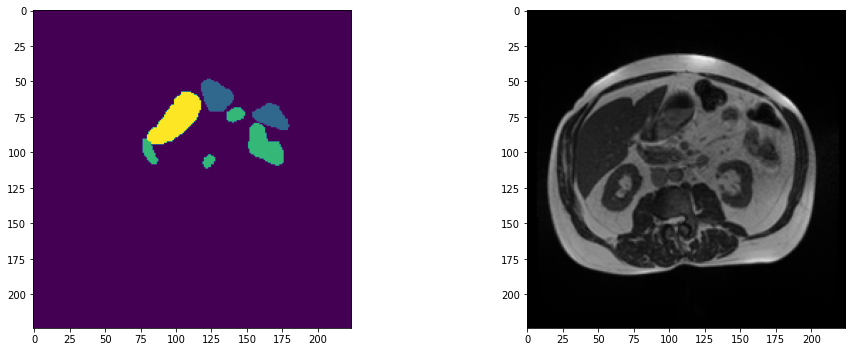

In [10]:
def tf_load_image(path):
    """ Load an image with the correct shape using only TF
    
    Args:
        path (tf.string): Path to the image to be loaded
        resize_to (tuple, optional): Size to reshape image
    
    Returns:
        3 channel tf.Constant image ready for training/inference
    
    """
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(img_bytes, channels=3, dtype=tf.uint16)
    # img = 255.*(img/tf.constant(32767, dtype=tf.uint16))
    img = 255.*(img/tf.reduce_max(img))
    img = tf.image.resize(img, (tf.constant(IMAGE_SHAPE[0]), tf.constant(IMAGE_SHAPE[1])))
    return img


def tf_load_mask(rle_strs, root_shape, style="multiclass"):
    """ TBD """
    tf_masks = [tf.cast(tf.image.resize(tf.expand_dims(rle_decode_tf(rle_str, root_shape), axis=-1), size=(tf.constant(SEG_SHAPE[0]), tf.constant(SEG_SHAPE[1])), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR), tf.uint8) for rle_str in rle_strs]
    
    if style=="multilabel":
        return tf.concat(tf_masks, axis=-1)
    else:        
        _tf_masks = tf.zeros((*SEG_SHAPE, 1), dtype=tf.uint8)
        _tf_masks = tf_masks[2]*tf.constant(3, dtype=tf.uint8) # small bowel = 3
        _tf_masks = tf.where(tf_masks[1]==tf.constant(1, dtype=tf.uint8), tf.constant(2, dtype=tf.uint8), _tf_masks) # small bowel = 2
        _tf_masks = tf.where(tf_masks[0]==tf.constant(1, dtype=tf.uint8), tf.constant(1, dtype=tf.uint8), _tf_masks) # large bowel = 1
        return _tf_masks

def augment_batch(img_batch, mask_batch):
    
    # Simple augmentation
    #if tf.random.uniform([])<=tf.constant(0.5):
    #    img_batch = tf.image.flip_left_right(img_batch)
    #    mask_batch = tf.image.flip_left_right(mask_batch)
        
    return img_batch, mask_batch

def model_preprocessing_train(img_batch, mask_batch):
    img_batch = img_batch/tf.constant(127.5)-tf.constant(1.0)
    return img_batch, mask_batch
    
def model_preprocessing_test(img_batch):
    img_batch = img_batch/tf.constant(127.5)-tf.constant(1.0)
    return img_batch

# Hyperparameters

SHUFFLE_BUFFER = max(BATCH_SIZE*25, 500)
AUTOTUNE = tf.data.AUTOTUNE

# Whether or not to train?
DO_TRAIN=False
if not DEBUG: DO_TRAIN=False

if DEBUG:
    train_ds = tf.data.Dataset.from_tensor_slices((sub_train_df.f_path, (sub_train_df.lb_seg_rle, sub_train_df.sb_seg_rle, sub_train_df.st_seg_rle), (sub_train_df.slice_w,sub_train_df.slice_h)))
    val_ds = tf.data.Dataset.from_tensor_slices((sub_val_df.f_path, (sub_val_df.lb_seg_rle, sub_val_df.sb_seg_rle, sub_val_df.st_seg_rle), (sub_val_df.slice_w,sub_val_df.slice_h)))

    train_ds = train_ds.map(lambda x,y,z: (tf_load_image(x), tf_load_mask(y,z,style=STYLE)), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x,y,z: (tf_load_image(x), tf_load_mask(y,z,style=STYLE)), num_parallel_calls=AUTOTUNE)

    train_ds = train_ds.shuffle(SHUFFLE_BUFFER)\
                       .batch(BATCH_SIZE, drop_remainder=True)\
                       .map(augment_batch, num_parallel_calls=AUTOTUNE)\
                       .map(model_preprocessing_train, num_parallel_calls=AUTOTUNE)\
                       .prefetch(AUTOTUNE)

    # we only shuffle the validation a little because we don't want 
    # drop_remainder to hit the same images over and over...
    val_ds = val_ds.shuffle(SHUFFLE_BUFFER//5)\
                   .batch(BATCH_SIZE, drop_remainder=True)\
                   .map(model_preprocessing_train, num_parallel_calls=AUTOTUNE)\
                   .prefetch(AUTOTUNE)
    
    for _img_batch, _mask_batch in train_ds.take(1):
        print(_img_batch.shape, _mask_batch.shape)
        _img=_img_batch[0]
        _mask=_mask_batch[0]
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(tf.cast(_mask, tf.float32))

        plt.subplot(1,2,2)
        plt.imshow(tf.cast((_img+1)*127.5, tf.uint8))

        plt.tight_layout()
        plt.show()
        
# We only need every third row (hence the iloc[::3])
test_ds = tf.data.Dataset.from_tensor_slices(ss_df.iloc[::3].f_path.tolist())
test_ds = test_ds.map(lambda x: tf_load_image(x), num_parallel_calls=AUTOTUNE)

# This should be deterministic... i.e. the order of images will match the order of IDs
test_ds = test_ds.batch(BATCH_SIZE)\
                 .map(model_preprocessing_test, num_parallel_calls=AUTOTUNE)\
                 .prefetch(AUTOTUNE)

In [11]:
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense, Dropout, concatenate


def convolution_block(block_input, num_filters=256, kernel_size=3,
                      dilation_rate=1, padding="same", use_bias=False,):
    """ TBD """
    x = tf.keras.layers.Conv2D(filters=num_filters, 
                               kernel_size=kernel_size, 
                               dilation_rate=dilation_rate, 
                               padding=padding, 
                               use_bias=use_bias, 
                               kernel_initializer=tf.keras.initializers.HeNormal())(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.Activation("relu")(x)
def SqueezeAndExcite(inputs, ratio=8):
        init = inputs
        filters = init.shape[-1]
        se_shape = (1, 1, filters)

        se = GlobalAveragePooling2D()(init)
        se = Reshape(se_shape)(se)
        se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
        x = init * se
        return x


def DilatedSpatialPyramidPooling(dspp_input):
    """ TBD """
    x = tf.keras.layers.AveragePooling2D(pool_size=(HIGH_FEAT_LAYER_OUTPUT_SHAPE[-3], 
                                                    HIGH_FEAT_LAYER_OUTPUT_SHAPE[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    
    # Get layers to concatenate
    out_pool = tf.keras.layers.UpSampling2D(size=(HIGH_FEAT_LAYER_OUTPUT_SHAPE[-3]//x.shape[1], 
                                                  HIGH_FEAT_LAYER_OUTPUT_SHAPE[-2]//x.shape[2]), 
                                            interpolation="bilinear")(x)
    _out_layers = [out_pool,]+\
                  [convolution_block(dspp_input, 256, _k, _d) for _k, _d in zip((1,3,3,3), (1,6,12,18))]
    
    output = convolution_block(tf.keras.layers.Concatenate(axis=-1)(_out_layers), kernel_size=1)

    return output


def DeeplabV3Plus(backbone, low_feat_layer, high_feat_layer, n_classes, weights="imagenet", dropout=0.2):
    
    _inputs = tf.keras.layers.Input(shape=(*IMAGE_SHAPE, 3))
    encoder_bb = backbone(weights=weights, include_top=False, input_tensor=_inputs)
    
    x = encoder_bb.get_layer(high_feat_layer).output
    x = tf.keras.layers.Dropout(dropout)(x)
    x = DilatedSpatialPyramidPooling(x)    
    
    input_a = tf.keras.layers.UpSampling2D(size=(IMAGE_SHAPE[0]//4//x.shape[1], 
                                                 IMAGE_SHAPE[1]//4//x.shape[2]), 
                                           interpolation="bilinear")(x)
    input_b = encoder_bb.get_layer(low_feat_layer).output
    input_b = tf.keras.layers.Dropout(dropout)(input_b)
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = SqueezeAndExcite(x)
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(size=(IMAGE_SHAPE[0]//x.shape[1], 
                                           IMAGE_SHAPE[1]//x.shape[2]), 
                                     interpolation="bilinear",)(x)
    x = SqueezeAndExcite(x)
    x = tf.keras.layers.Dropout(dropout/2)(x)
    _outputs = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=_inputs, outputs=_outputs)

# If you change the backbone you will need to adjust this accordingly
BACKBONE = tf.keras.applications.ResNet50
RES_HIGH_FEAT_LAYER = "conv4_block6_2_relu"
RES_LOW_FEAT_LAYER = "conv2_block3_2_relu"
_dummy_model = BACKBONE(include_top=False, weights=None, input_shape=(*IMAGE_SHAPE, 3))
HIGH_FEAT_LAYER_OUTPUT_SHAPE = _dummy_model.get_layer(RES_HIGH_FEAT_LAYER).output_shape[1:]
LOW_FEAT_LAYER_OUTPUT_SHAPE = _dummy_model.get_layer(RES_LOW_FEAT_LAYER).output_shape[1:]

SUB_NODEBUG_MODEL_WT_PATH = "/kaggle/input/uwmgit-deeplabv3-end-to-end-pipeline-tf/resnet50_224x224x3_multiclass"

if STYLE=="multiclass":
    N_CLASSES = len(classes)+1 # n_classses+background
else:
    N_CLASSES = len(classes) # n_classses (binary so background is 0 in each channel)

MODEL_INSPECT = "summary"

# We need this locally if we want to do all of this stuff without internet...
WEIGHT_PATH = "/kaggle/input/tf-keras-pretrained-model-weights/No Top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

deeplabv3plus = DeeplabV3Plus(backbone=BACKBONE, weights=WEIGHT_PATH,
                              low_feat_layer=RES_LOW_FEAT_LAYER, 
                              high_feat_layer=RES_HIGH_FEAT_LAYER, 
                              n_classes=N_CLASSES)

if MODEL_INSPECT=="plot":
    display(tf.keras.utils.plot_model(deeplabv3plus))
elif MODEL_INSPECT=="summary":
    print(deeplabv3plus.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
# Custom Callback To Include in Callbacks List At Training Time

@tf.function
def dice_loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true * y_true) + tf.reduce_sum(y_pred * y_pred) - tf.reduce_sum(y_true * y_pred)

    return 1 - numerator / denominator

class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

   
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

def plot_history(_history, fold_num="1", metrics=("acc","mean_iou")):
    """ TBD """
    fig = px.line(_history.history, 
                  x=range(len(_history.history["loss"])), 
                  y=["loss", "val_loss"],
                  labels={"value":"Loss (log-axis)", "x":"Epoch #"},
                  title=f"<b>FOLD {fold_num} MODEL - LOSS</b>", log_y=True
                  )
    fig.show()

    for _m in metrics:
        fig = px.line(_history.history, 
                      x=range(len(_history.history[_m])), 
                      y=[_m, f"val_{_m}"],
                      labels={"value":f"{_m} (log-axis)", "x":"Epoch #"},
                      title=f"<b>FOLD {fold_num} MODEL - {_m}</b>", log_y=True)
        fig.show()    

N_EPOCH = 50
OPTIMIZER = tf.keras.optimizers.Adam(0.00075)
if STYLE=="multiclass":
    LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
else:
    LOSS = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True)
        
METRICS = [ UpdatedMeanIoU(num_classes=N_CLASSES, name="mean_iou"),"acc"]

_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                                                  patience=2, verbose=1, mode="min")
_es_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss",  patience=4, 
                                              verbose=1, mode="min",
                                              restore_best_weights=True)
_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(f'./resnet50_{IMAGE_SHAPE[0]}x{IMAGE_SHAPE[1]}x3_{STYLE}', 
                                                  monitor='val_loss', mode="min",
                                                  save_best_only=True, options=save_locally)
_gc_cb = GarbageCollectorCallback()
CB_LIST = [_es_cb, _ckpt_cb, _lr_cb, _gc_cb]

deeplabv3plus.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
history = deeplabv3plus.fit(train_ds, validation_data=val_ds, epochs=20)
plot_history(history)


Epoch 1/20


2022-05-22 17:05:53.141308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 716 of 800
2022-05-22 17:05:54.167336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-05-22 17:05:55.802668: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


599/599 [==============================] - 643s 1s/step - loss: 0.0409 - mean_iou: 0.5466 - acc: 0.9877 - val_loss: 0.1069 - val_mean_iou: 0.2715 - val_acc: 0.9826
Epoch 2/20


2022-05-22 17:16:30.360511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 771 of 800
2022-05-22 17:16:31.007882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 576s 943ms/step - loss: 0.0144 - mean_iou: 0.7669 - acc: 0.9944 - val_loss: 0.0407 - val_mean_iou: 0.5652 - val_acc: 0.9888
Epoch 3/20


2022-05-22 17:26:52.283395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 756 of 800
2022-05-22 17:26:52.868904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 580s 952ms/step - loss: 0.0119 - mean_iou: 0.8056 - acc: 0.9954 - val_loss: 0.0314 - val_mean_iou: 0.6241 - val_acc: 0.9905
Epoch 4/20


2022-05-22 17:37:14.209904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 759 of 800
2022-05-22 17:37:14.749186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 584s 958ms/step - loss: 0.0108 - mean_iou: 0.8224 - acc: 0.9958 - val_loss: 0.0329 - val_mean_iou: 0.6237 - val_acc: 0.9909
Epoch 5/20


2022-05-22 17:47:36.149928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 728 of 800
2022-05-22 17:47:37.024043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 577s 945ms/step - loss: 0.0096 - mean_iou: 0.8392 - acc: 0.9962 - val_loss: 0.0341 - val_mean_iou: 0.6256 - val_acc: 0.9908
Epoch 6/20


2022-05-22 17:57:58.067099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 676 of 800
2022-05-22 17:57:59.519730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 582s 952ms/step - loss: 0.0091 - mean_iou: 0.8467 - acc: 0.9964 - val_loss: 0.0433 - val_mean_iou: 0.6030 - val_acc: 0.9902
Epoch 7/20


2022-05-22 18:07:40.057017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 654 of 800
2022-05-22 18:07:41.826376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 582s 952ms/step - loss: 0.0090 - mean_iou: 0.8484 - acc: 0.9964 - val_loss: 0.0497 - val_mean_iou: 0.5459 - val_acc: 0.9884
Epoch 8/20


2022-05-22 18:18:01.992296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 717 of 800
2022-05-22 18:18:02.963304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 577s 946ms/step - loss: 0.0085 - mean_iou: 0.8541 - acc: 0.9965 - val_loss: 0.0472 - val_mean_iou: 0.5530 - val_acc: 0.9891
Epoch 9/20


2022-05-22 18:27:39.506222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 702 of 800
2022-05-22 18:27:40.635520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 576s 943ms/step - loss: 0.0084 - mean_iou: 0.8570 - acc: 0.9966 - val_loss: 0.0749 - val_mean_iou: 0.4661 - val_acc: 0.9869
Epoch 10/20


2022-05-22 18:38:01.429678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 680 of 800
2022-05-22 18:38:02.837643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 587s 961ms/step - loss: 0.0082 - mean_iou: 0.8602 - acc: 0.9967 - val_loss: 0.0520 - val_mean_iou: 0.5540 - val_acc: 0.9888
Epoch 11/20


2022-05-22 18:47:48.581435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 666 of 800
2022-05-22 18:47:50.156145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 583s 954ms/step - loss: 0.0077 - mean_iou: 0.8681 - acc: 0.9969 - val_loss: 0.0558 - val_mean_iou: 0.5480 - val_acc: 0.9887
Epoch 12/20


2022-05-22 18:58:10.515331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 764 of 800
2022-05-22 18:58:10.943569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 573s 940ms/step - loss: 0.0076 - mean_iou: 0.8698 - acc: 0.9969 - val_loss: 0.0343 - val_mean_iou: 0.6599 - val_acc: 0.9915
Epoch 13/20


2022-05-22 19:08:32.436298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 750 of 800
2022-05-22 19:08:33.031447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 586s 962ms/step - loss: 0.0075 - mean_iou: 0.8707 - acc: 0.9969 - val_loss: 0.0510 - val_mean_iou: 0.5633 - val_acc: 0.9893
Epoch 14/20
599/599 [==============================] - 648s 1s/step - loss: 0.0074 - mean_iou: 0.8730 - acc: 0.9970 - val_loss: 0.0584 - val_mean_iou: 0.5184 - val_acc: 0.9881
Epoch 15/20


2022-05-22 19:30:16.300164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 743 of 800
2022-05-22 19:30:16.993524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 589s 966ms/step - loss: 0.0074 - mean_iou: 0.8726 - acc: 0.9970 - val_loss: 0.0463 - val_mean_iou: 0.5081 - val_acc: 0.9875
Epoch 16/20


2022-05-22 19:40:38.224487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 794 of 800
2022-05-22 19:40:38.295031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 585s 960ms/step - loss: 0.0071 - mean_iou: 0.8767 - acc: 0.9971 - val_loss: 0.0484 - val_mean_iou: 0.6204 - val_acc: 0.9903
Epoch 17/20
599/599 [==============================] - 646s 1s/step - loss: 0.0068 - mean_iou: 0.8830 - acc: 0.9972 - val_loss: 0.0368 - val_mean_iou: 0.6557 - val_acc: 0.9911
Epoch 18/20


2022-05-22 20:01:46.367358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 481 of 800
2022-05-22 20:01:50.245760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 589s 961ms/step - loss: 0.0063 - mean_iou: 0.8891 - acc: 0.9974 - val_loss: 0.0388 - val_mean_iou: 0.6585 - val_acc: 0.9913
Epoch 19/20
599/599 [==============================] - 590s 969ms/step - loss: 0.0060 - mean_iou: 0.8941 - acc: 0.9975 - val_loss: 0.0638 - val_mean_iou: 0.5607 - val_acc: 0.9892
Epoch 20/20


2022-05-22 20:22:30.209329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 789 of 800
2022-05-22 20:22:30.334715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


599/599 [==============================] - 587s 963ms/step - loss: 0.0065 - mean_iou: 0.8878 - acc: 0.9973 - val_loss: 0.0567 - val_mean_iou: 0.5678 - val_acc: 0.9892


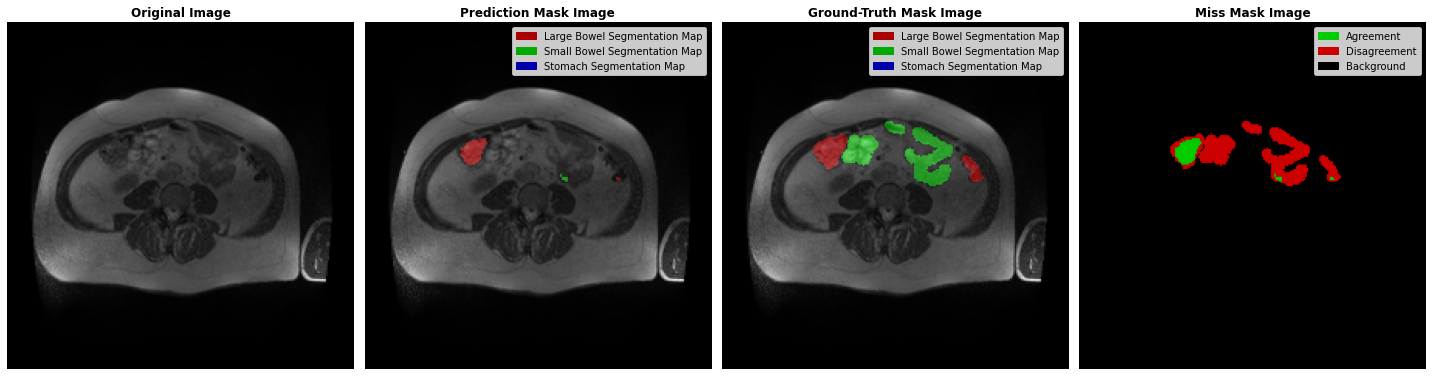

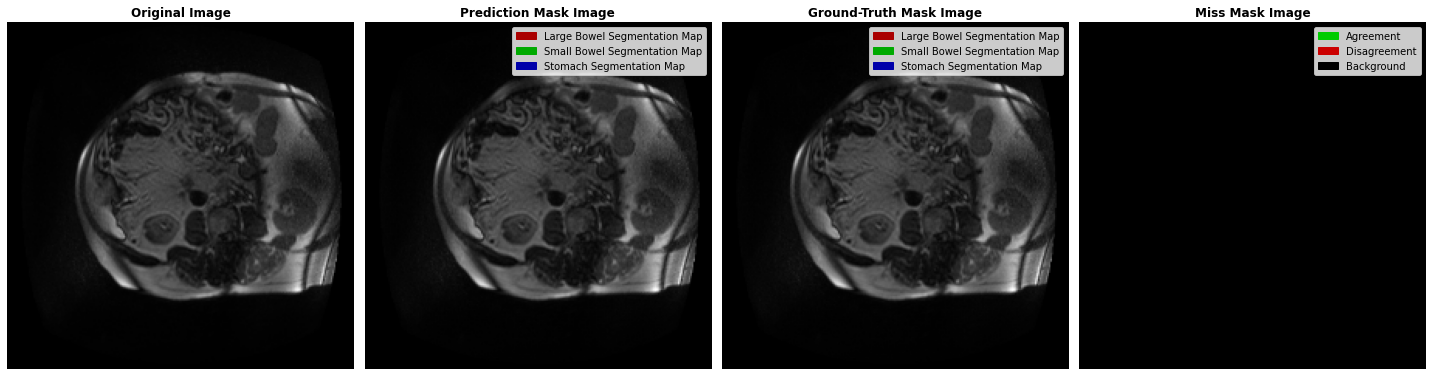

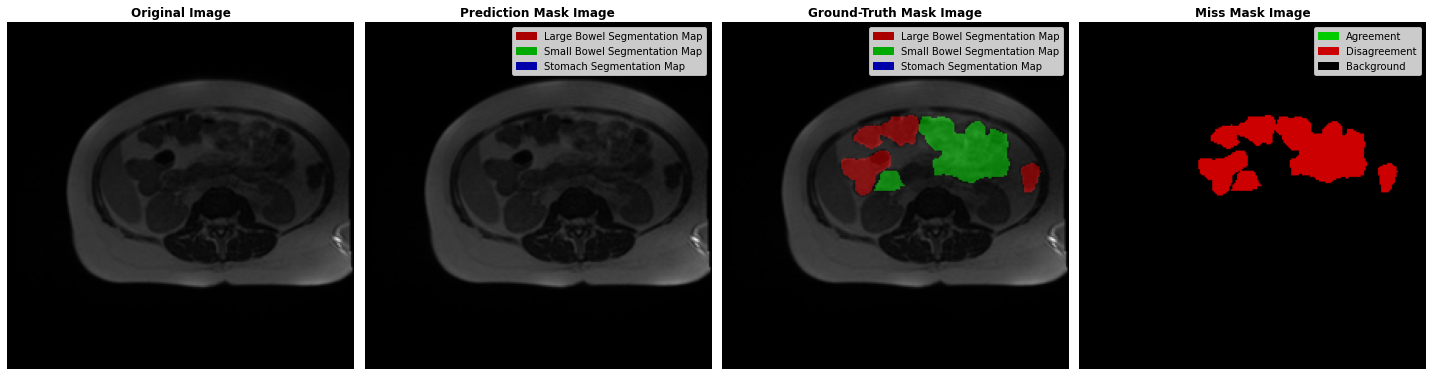

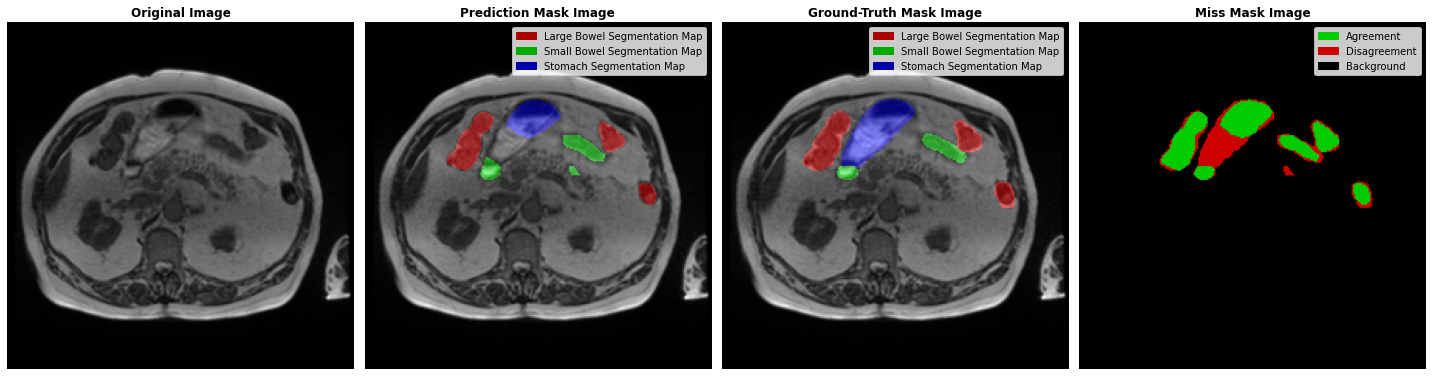

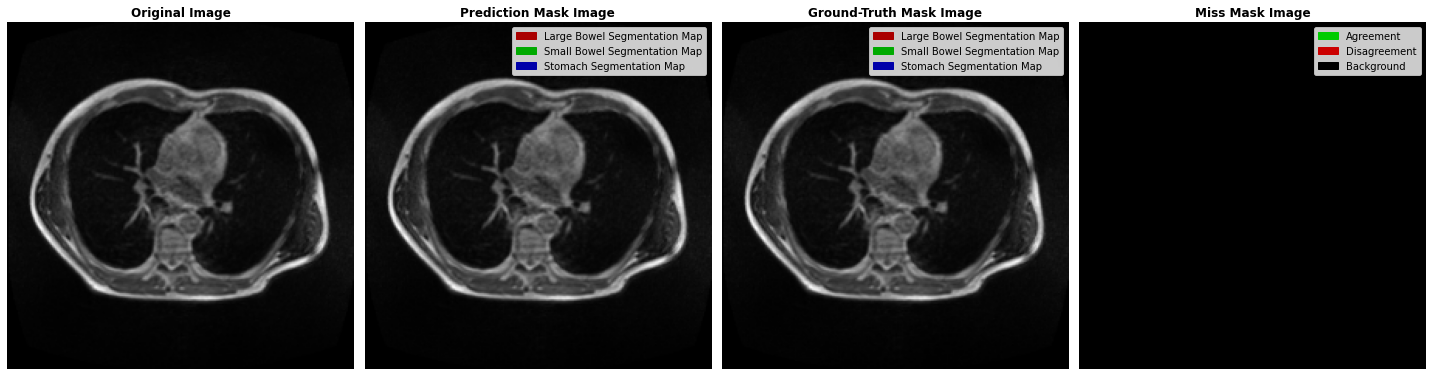

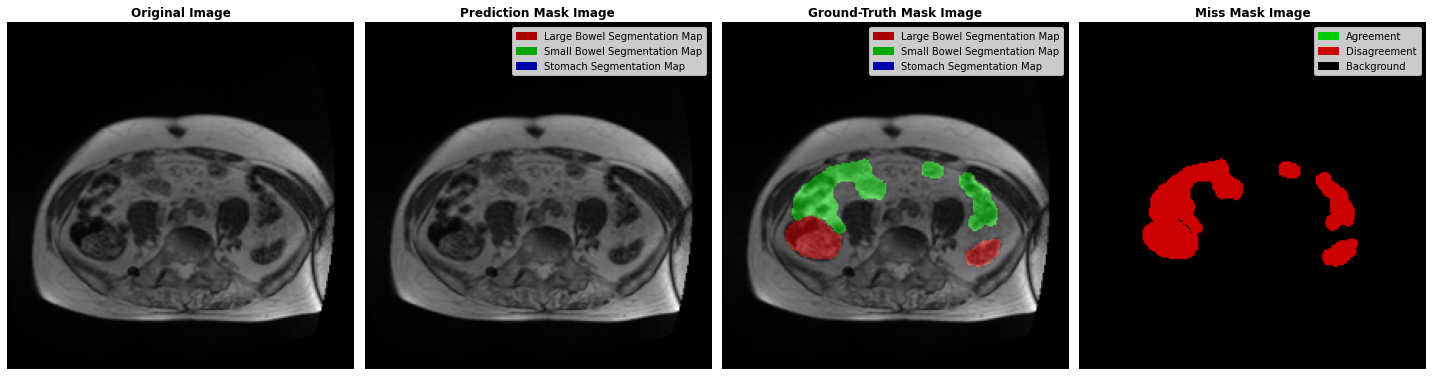

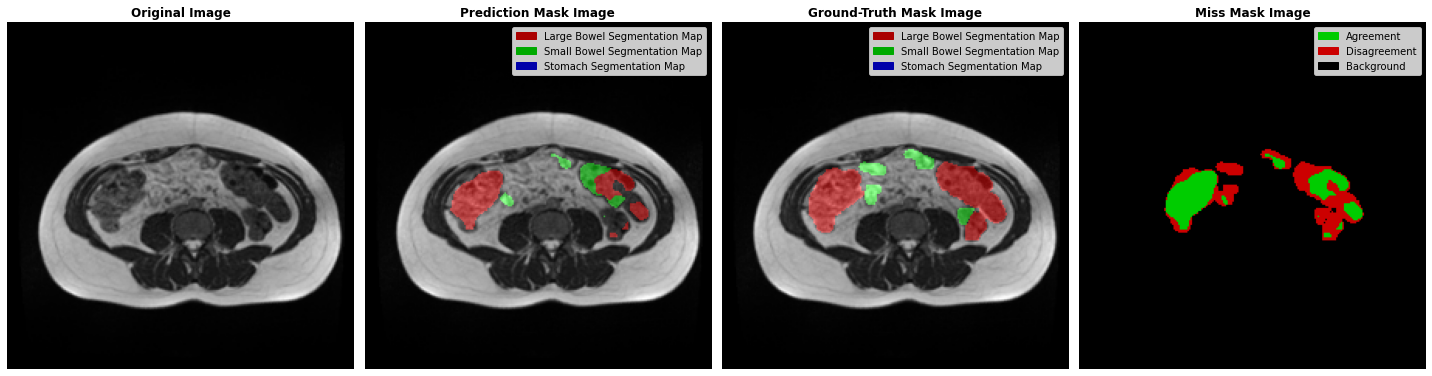

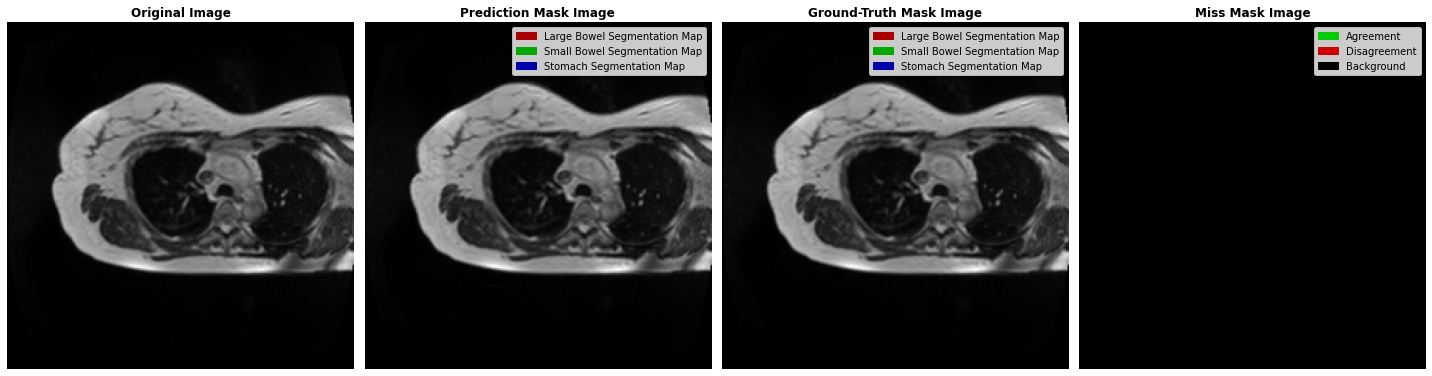

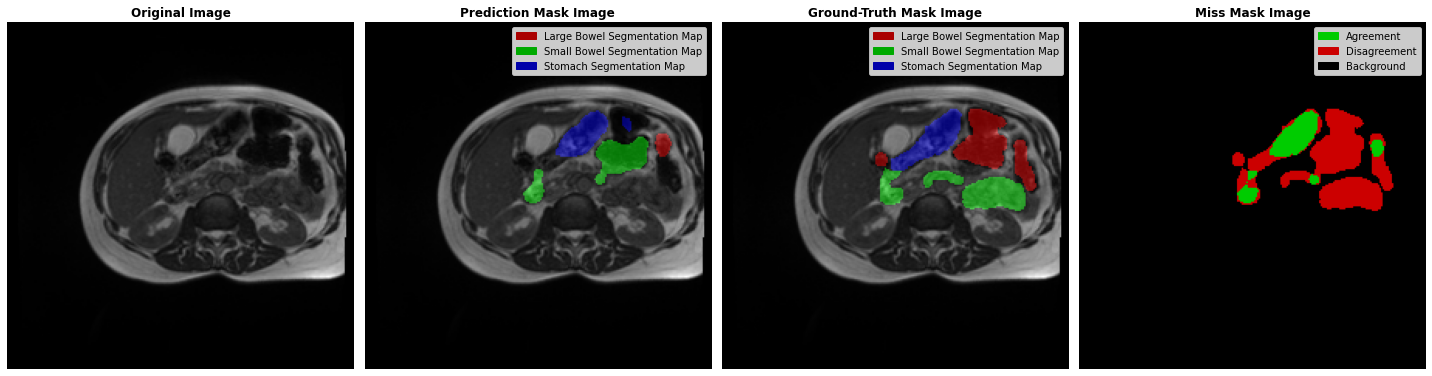

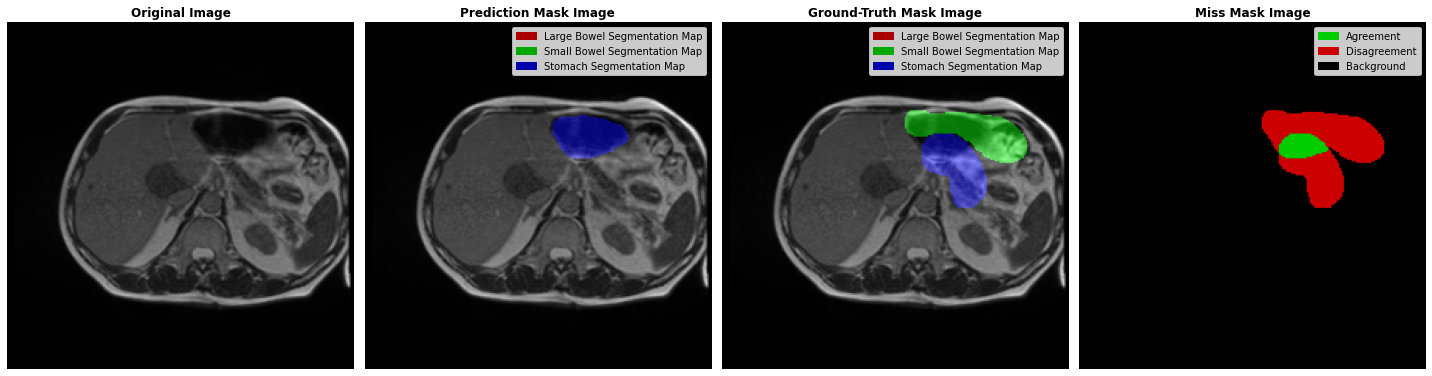

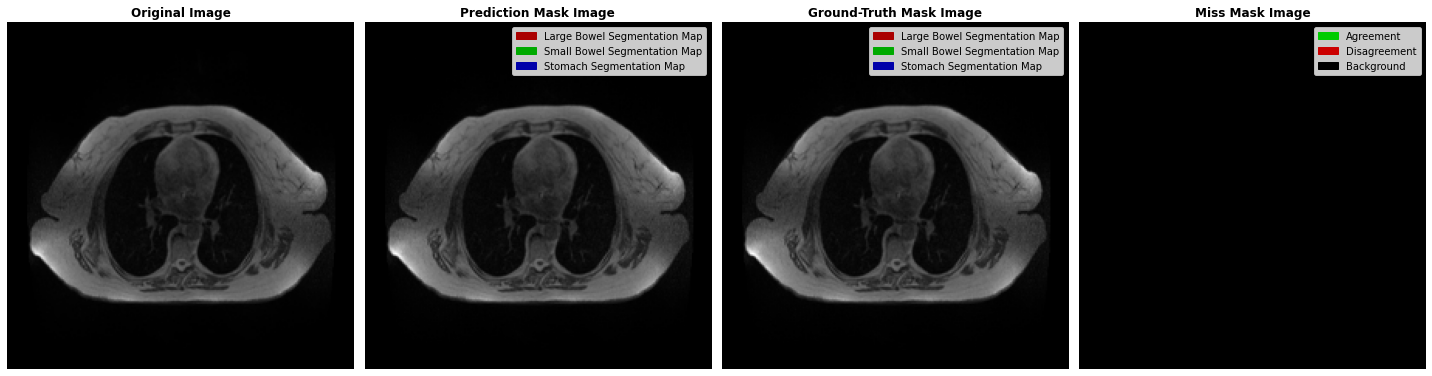

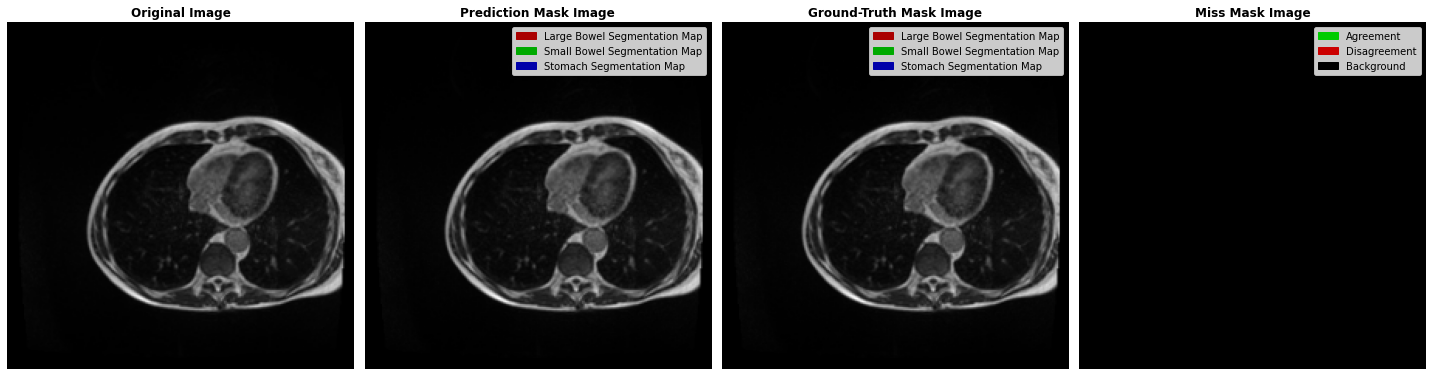

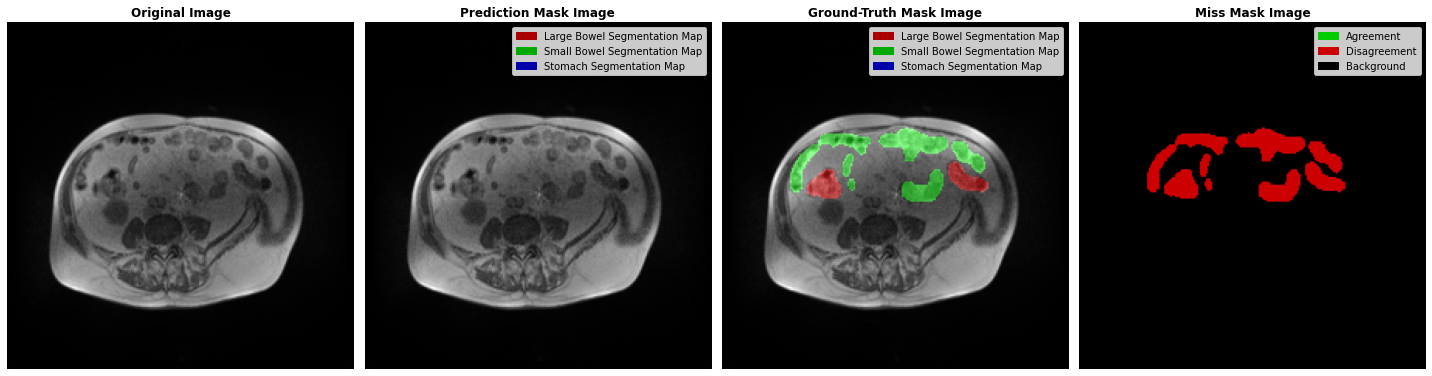

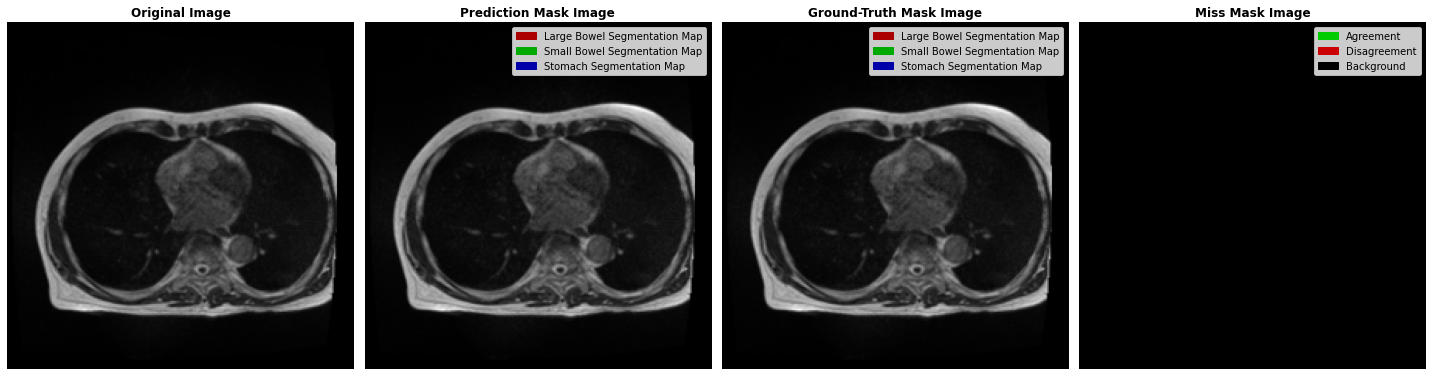

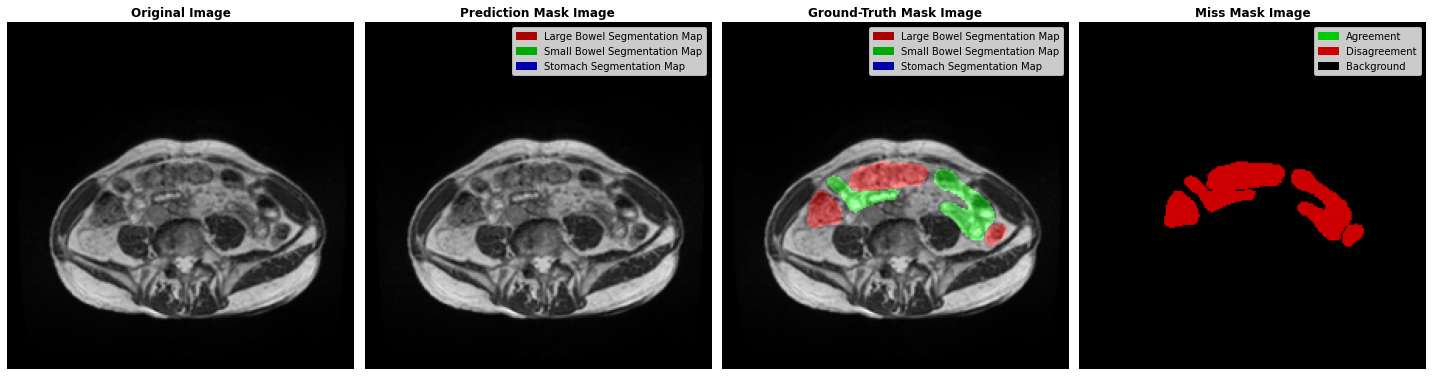

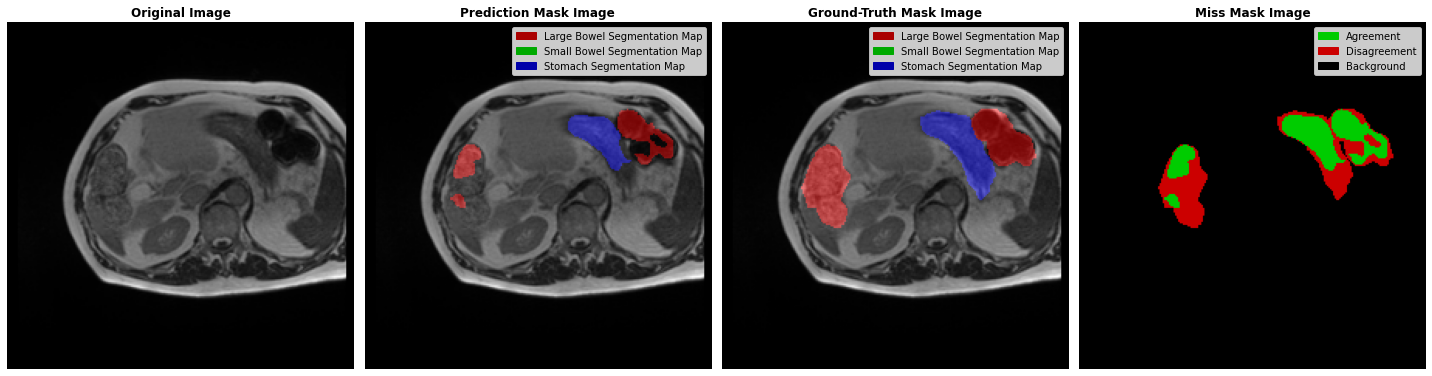

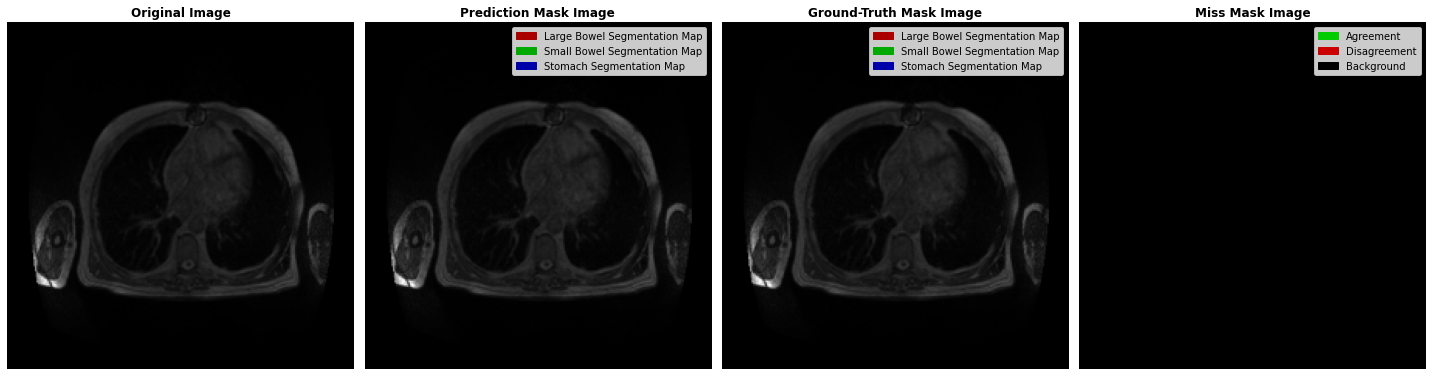

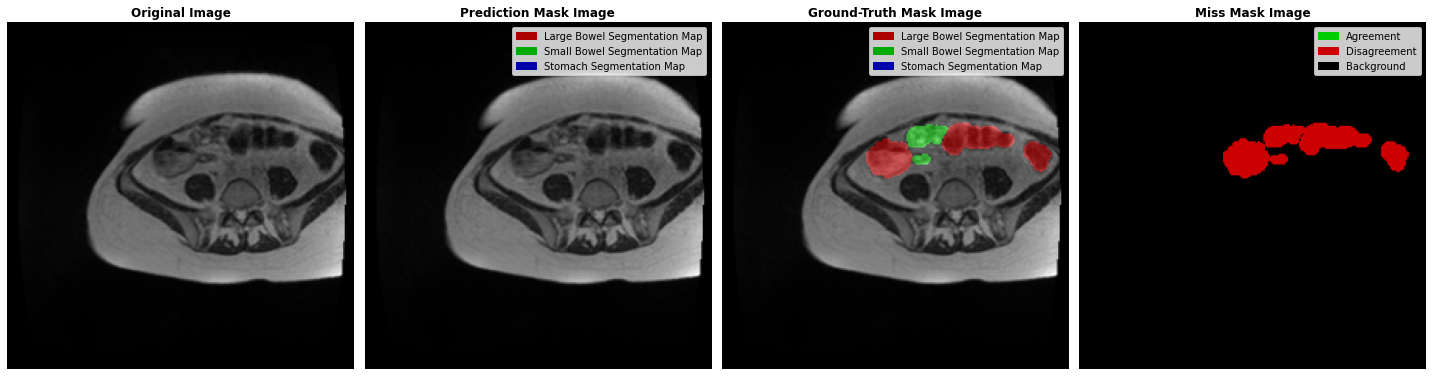

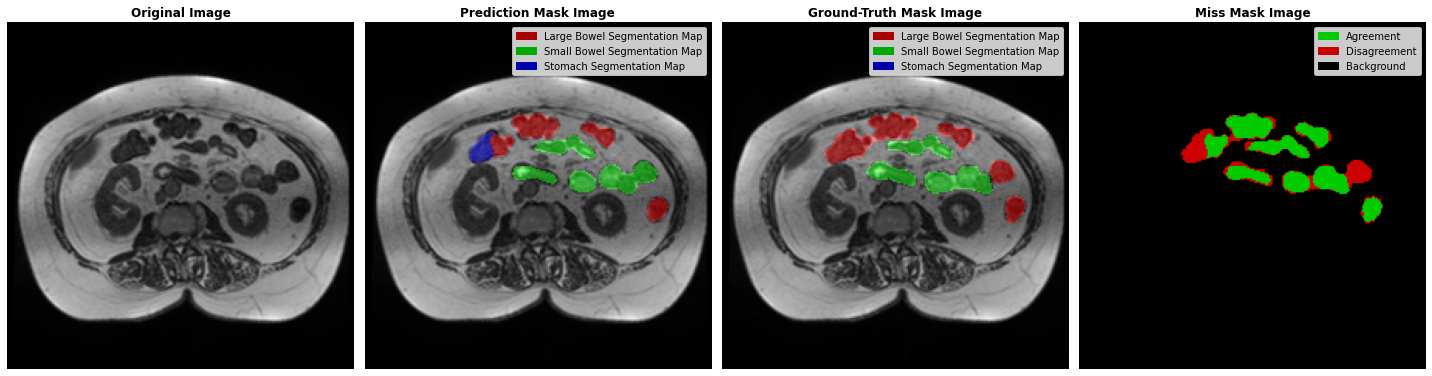

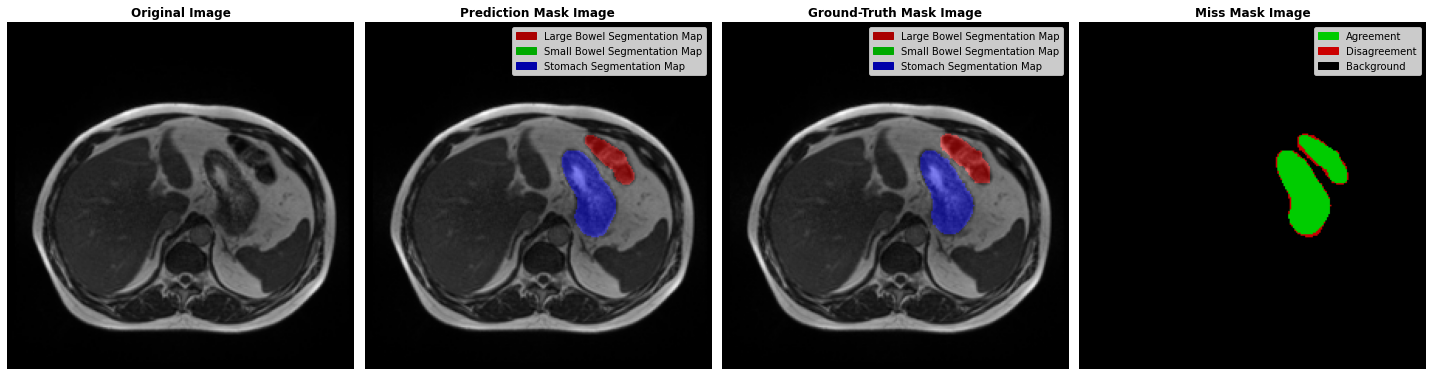

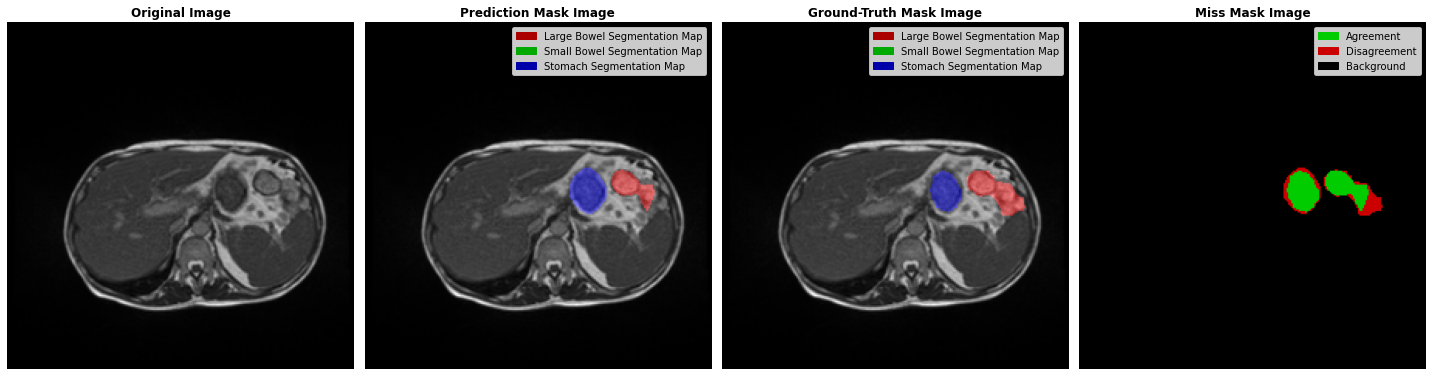

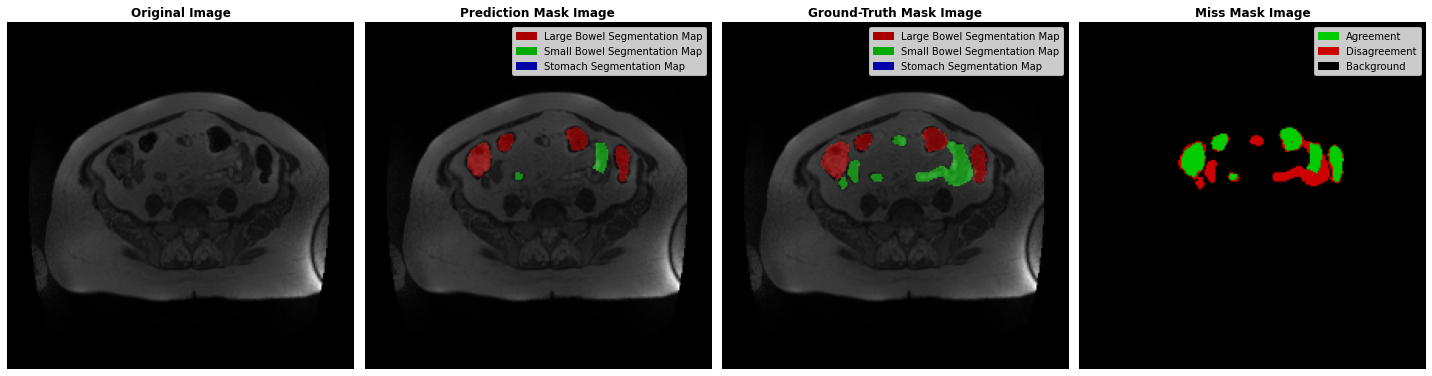

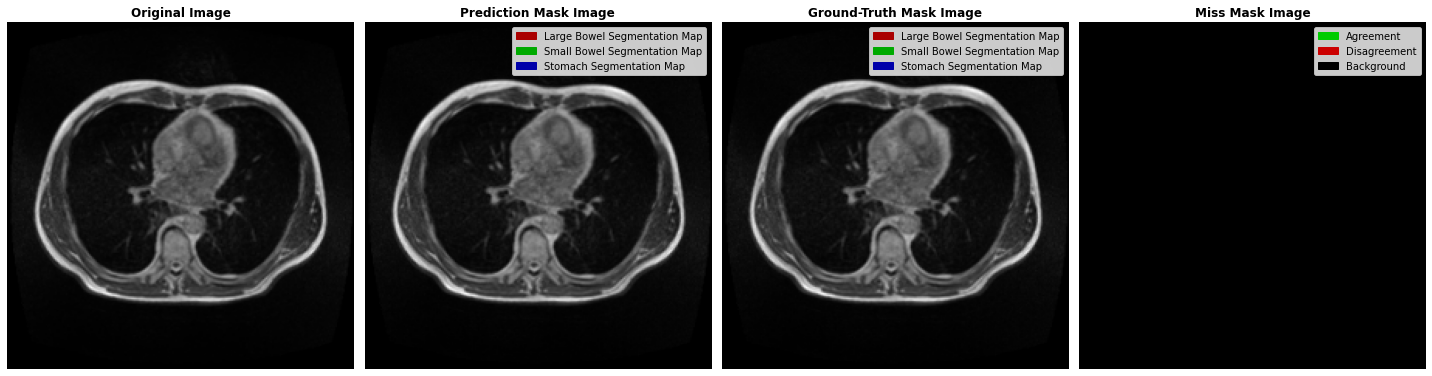

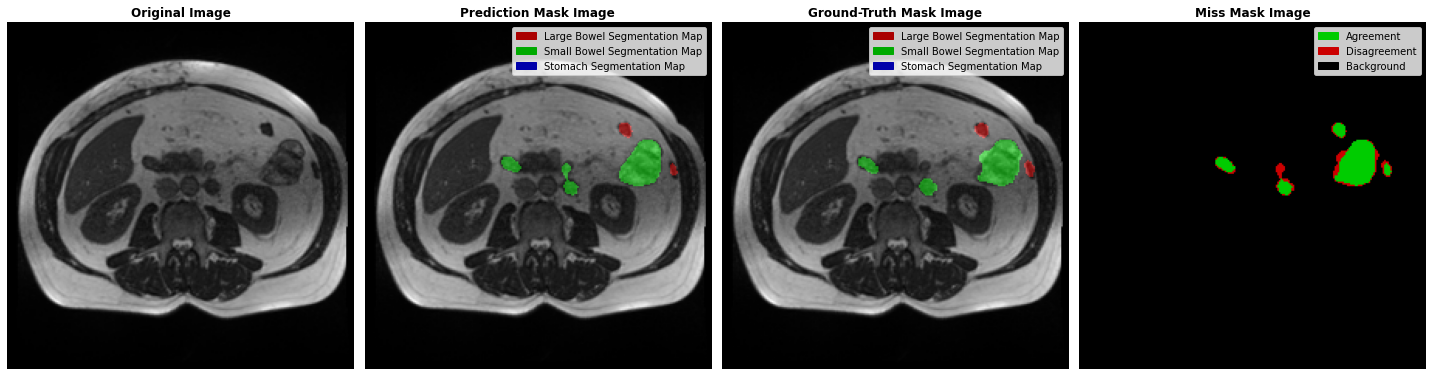

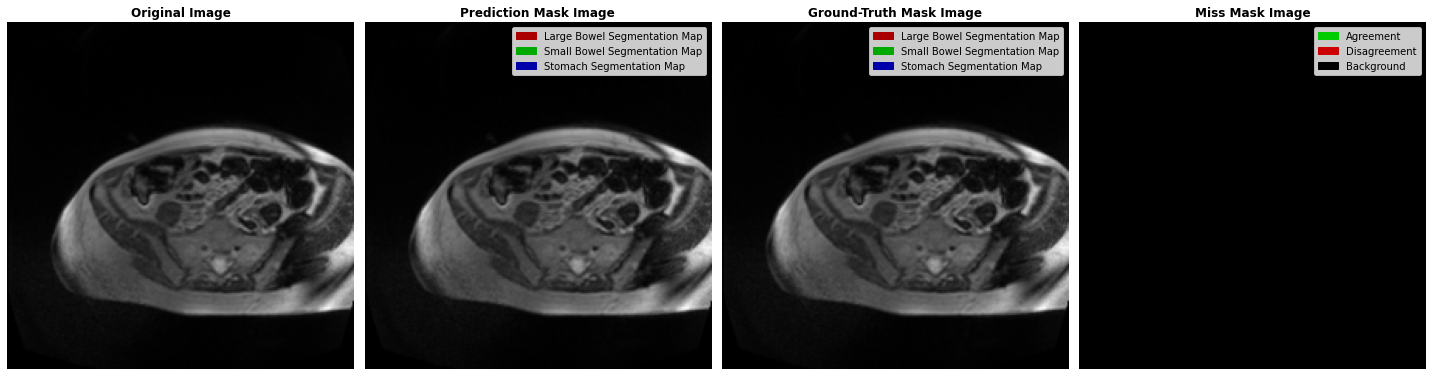

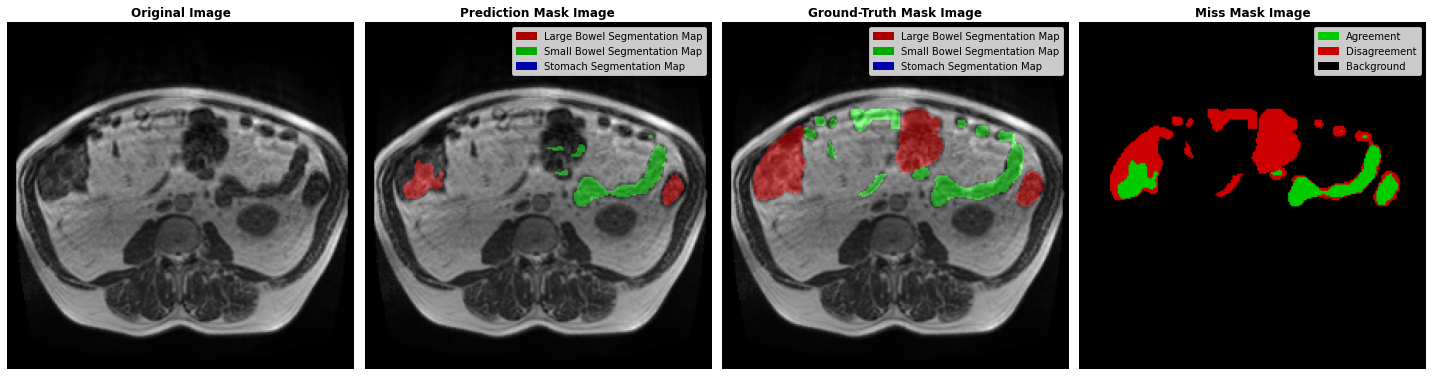

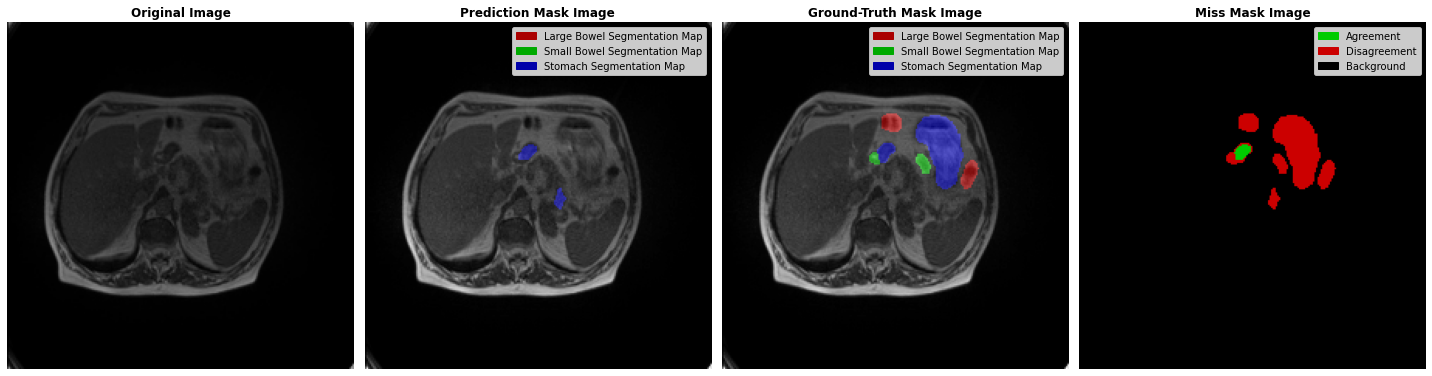

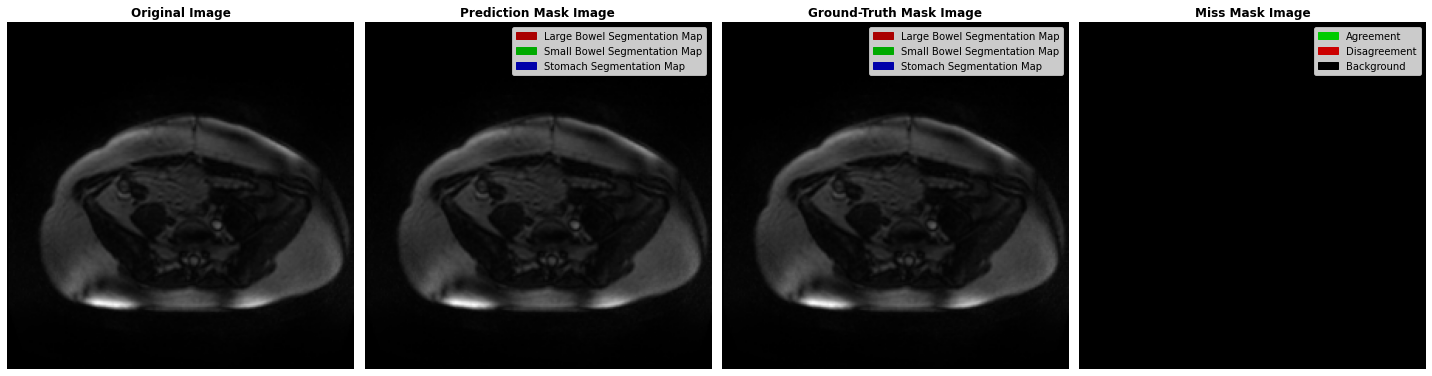

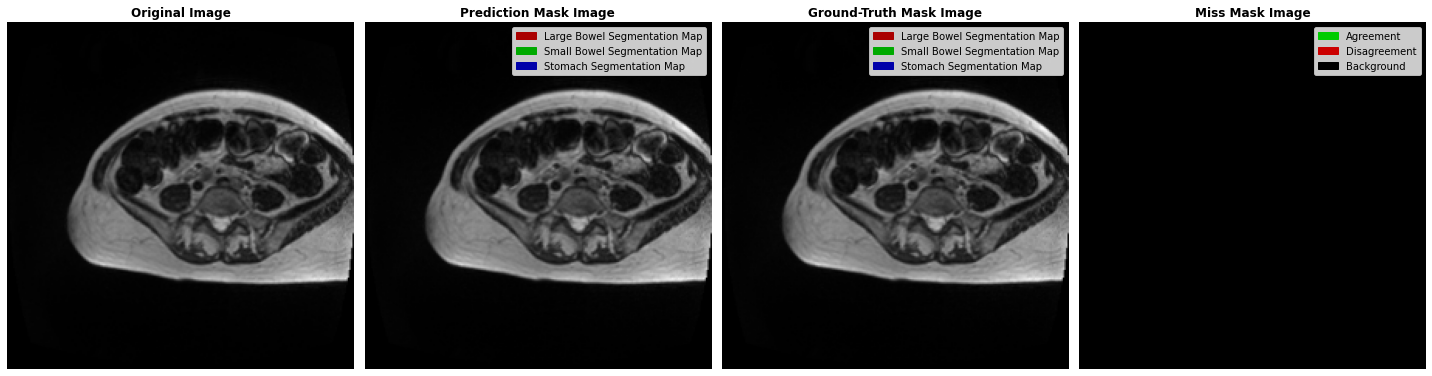

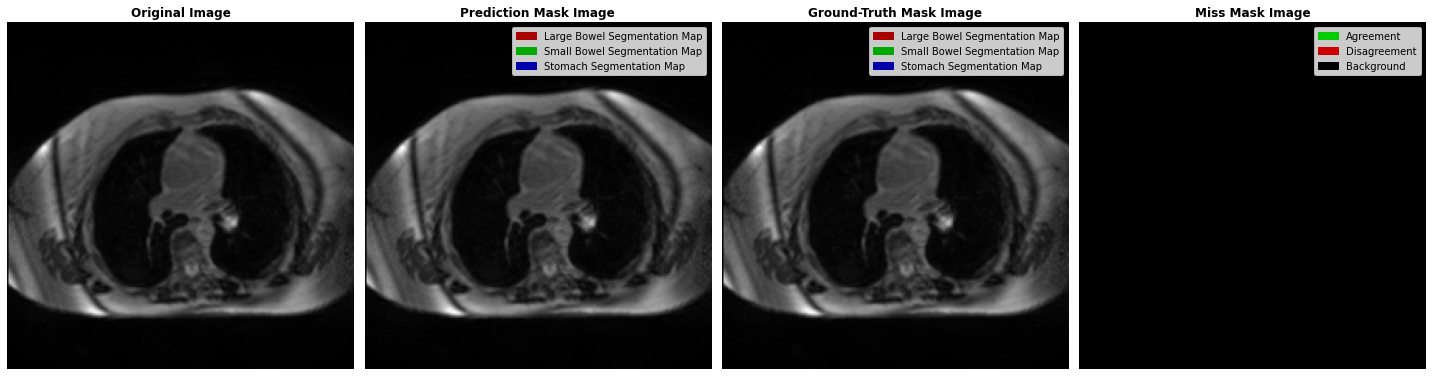

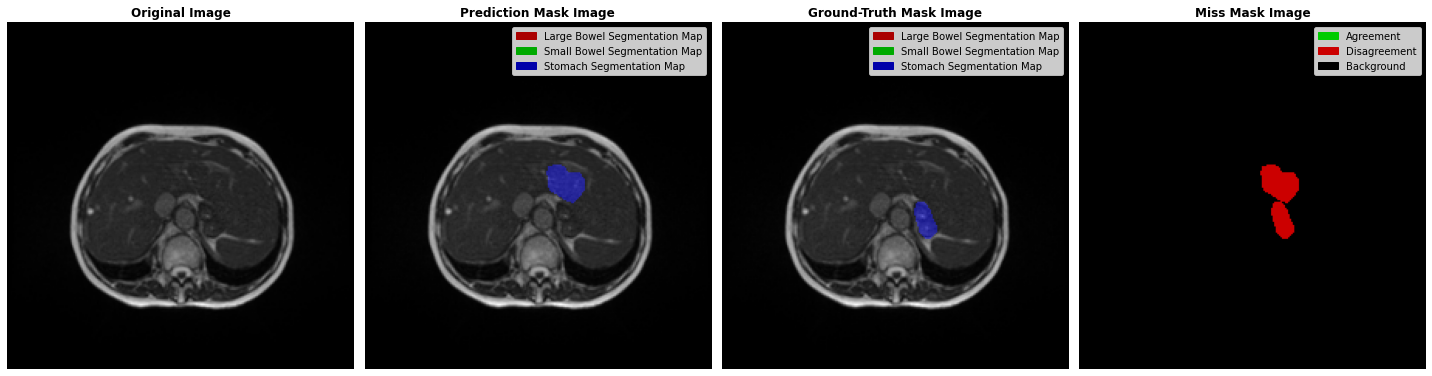

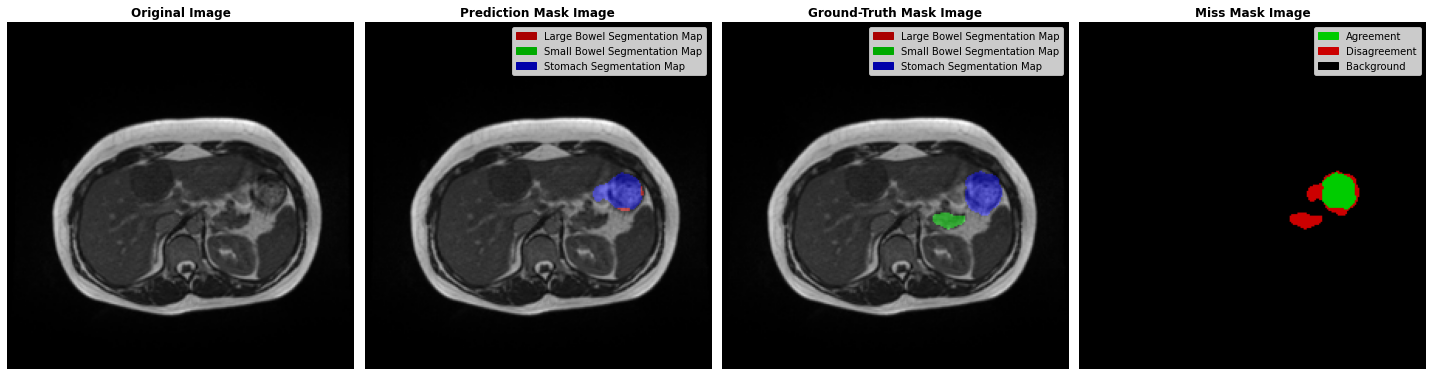

In [13]:
def get_overlay(img, mask, _alpha=0.999, _beta=0.45, _gamma=0):
    
    # Normalize to be between 0-1 (float32)
    img = (img/img.max()).astype(np.float32)
    
    # Make mask RGB and float32
    if len(mask.shape)==2:
        mask_rgb = np.zeros_like(img, dtype=np.float32)
        mask_rgb[..., 2] = np.where(mask==3, 1.0, 0.0)
        mask_rgb[..., 1] = np.where(mask==2, 1.0, 0.0)
        mask_rgb[..., 0] = np.where(mask==1, 1.0, 0.0)
    else:
        mask_rgb=mask.astype(np.float32)
    
    # overlay
    seg_overlay = cv2.addWeighted(src1=img, alpha=_alpha, 
                                  src2=mask_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def get_miss_overlay(gt_mask, pred_mask, _alpha=0.9, _beta=0.25, _gamma=0):
    
    # Make mask RGB and float32
    miss_rgb = np.zeros((*pred_mask.shape[:2],3), dtype=np.float32)
    
    if len(pred_mask.shape)==2:
        miss_rgb[..., 1] = np.where((gt_mask==pred_mask)&(gt_mask!=0), 0.8, 0.0)
        miss_rgb[..., 0] = np.where((gt_mask!=pred_mask), 0.8, 0.0)
    else:
        
        miss_rgb = np.where((gt_mask==pred_mask)&(gt_mask!=0.0), (0.0,0.8,0.0), (0.0,0.0,0.0))
        miss_rgb = np.where((gt_mask!=pred_mask), (0.8,0.0,0.0), miss_rgb)
        
    return miss_rgb

def plot_preds(img, pred_mask, gt_mask):
    gt_overlay = get_overlay(img, gt_mask)
    pred_overlay = get_overlay(img, pred_mask)
    miss_overlay = get_miss_overlay(gt_mask, pred_mask)
    
    plt.figure(figsize=(20,12))
    
    for i, (_desc, _img) in enumerate(zip(["Original", "Prediction Mask", "Ground-Truth Mask", "Miss Mask"], [img, pred_overlay, gt_overlay, miss_overlay])):        
        plt.subplot(1,4,i+1)
        plt.imshow(_img)
        plt.title(f"{_desc} Image", fontweight="bold")        
        plt.axis(False)
        
        if i in [1,2]:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
            labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
            plt.legend(handles,labels)
        elif i==3:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.0,0.8,0.0), (0.8,0.0,0.0), (0.0, 0.0, 0.0)]]
            labels = ["Agreement", "Disagreement", "Background"]
            plt.legend(handles,labels)
    plt.tight_layout()
    plt.show()

if DEBUG:
    for img_batch, mask_batch in val_ds.take(1):
        pred_batch = deeplabv3plus(img_batch)

        if STYLE=="multilabel":
            pred_batch = np.where(tf.nn.sigmoid(pred_batch)>=0.1, 1.0, 0.0)
        else:
            pred_batch = np.argmax(pred_batch, axis=-1)

        img_batch = ((img_batch+1)*127.5).numpy().astype(np.int32)
        mask_batch = mask_batch.numpy().squeeze().astype(np.float32)
        break

    for _img, _pred, _mask in zip(img_batch, pred_batch, mask_batch):
        plot_preds(_img, _pred, _mask)

In [15]:
def pred_2_rle(pred_arr, root_shape):
    
    # Get correct size pred array based on initial slice size
    pred_arr = cv2.resize(pred_arr, root_shape, interpolation=cv2.INTER_NEAREST)
    
    # Get individual segmentation masks
    lb_mask = np.where(pred_arr==1,1,0)
    sb_mask = np.where(pred_arr==2,1,0)
    st_mask = np.where(pred_arr==3,1,0)
    
    return rle_encode(lb_mask), rle_encode(sb_mask), rle_encode(st_mask)

N_TEST = int(np.ceil((len(ss_df)//3)/BATCH_SIZE))

# Loop over batches and get prediction
for i, img_batch in tqdm(enumerate(test_ds), total=N_TEST):
    
    # Cleanup every so often
    if i%100==0:
        gc.collect(); gc.collect(); tf.keras.backend.clear_session(); gc.collect()    
    
    # Get predictions
    pred_batch = tf.argmax(deeplabv3plus(img_batch, training=False), axis=-1).numpy()
    
    # Loop over prediction and determine submission dataframe index (3*individual-count because of reduced inference size)
    for j, _pred in enumerate(pred_batch):
        df_idx = 3*(i*BATCH_SIZE+j)
        pred_rles = pred_2_rle(_pred, (ss_df.iloc[df_idx]["slice_h"], ss_df.iloc[df_idx]["slice_w"]))
        
        # Loop over rles and assign the correct row of the submission dataframe
        for k,pred_rle in enumerate(pred_rles):
            ss_df.loc[df_idx+k, "predicted"] = pred_rle
            
ss_df = ss_df[["id", "class", "predicted"]]
ss_df.to_csv("submission.csv", index=False)
display(ss_df)

  0%|          | 0/683 [00:00<?, ?it/s]

id        class predicted
0      case123_day20_slice_0001  large_bowel          
1      case123_day20_slice_0001  small_bowel          
2      case123_day20_slice_0001      stomach          
3      case123_day20_slice_0002  large_bowel          
4      case123_day20_slice_0002  small_bowel          
...                         ...          ...       ...
65563  case124_day19_slice_0143  small_bowel          
65564  case124_day19_slice_0143      stomach          
65565  case124_day19_slice_0144  large_bowel          
65566  case124_day19_slice_0144  small_bowel          
65567  case124_day19_slice_0144      stomach          

[65568 rows x 3 columns]